CS-671 Deep Learning and Applications | Assignment 4

B20138 Titiksha Behal

# Libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.decomposition import PCA  # to apply PCA
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns  # to plot the heat maps
from sklearn.metrics import confusion_matrix


# Loading data and its representation

In [ ]:
# Mounting to google drive
from google.colab import drive
#drive.mount('/content/gdrive')
!unzip '/content/Group_8.zip'

In [9]:
# read the files
directory= "/content/Group_8"
classes = os.listdir(os.path.join(directory,"train"))

# loading images and converting them to ndarray
def read_data (dataset_path) :
  data=[]
  for c in classes :
    lab = [0]*len(classes)
    lab[classes.index(c)] = 1
    path=os.path.join(dataset_path,c)
    for image in os.listdir(path) :
      img_data=(cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE).reshape(28,28)).astype(np.float64)
      data.append((img_data,lab))
  np.random.shuffle(data)
  return data

In [10]:
train=read_data(os.path.join(directory,"train"))
validation=read_data(os.path.join(directory,"val"))
test=read_data(os.path.join(directory,"test"))

In [ ]:
print("Classes are :",classes)
print(len(train),"training samples read")
print(len(validation),"validation samples read")
print(len(test),"test samples read")

Classes are : ['3', '1', '8', '9', '4']
11395 training samples read
3815 validation samples read
3795 test samples read


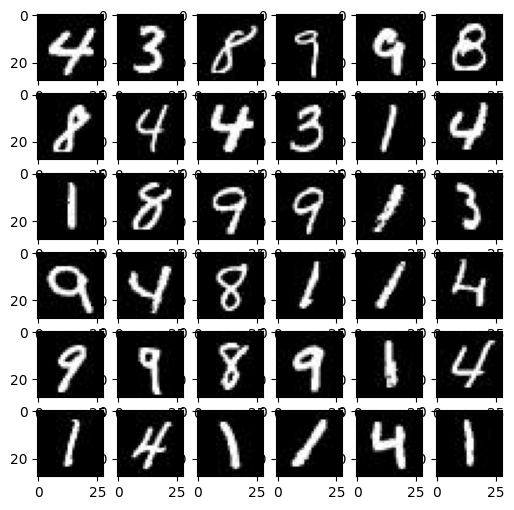

In [ ]:
# visualising MNIST training data
fig=plt.figure(figsize=(6,6))
for i in range(36) :
  fig.add_subplot(6,6,i+1)
  plt.imshow(train[i][0],cmap="gray")
plt.show()

Label : 4


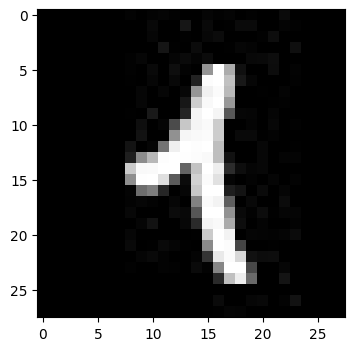

In [ ]:
# display a random image with it's label
ind = np.random.randint(0,len(train))
print("Label :",classes[np.argmax(train[ind][1])])
fig=plt.figure(figsize=(4,4))
plt.imshow(train[ind][0],cmap="gray")
plt.show()

In [11]:
# flatten the data
train_ip=np.array([var.reshape(-1) for var, _ in train]).astype(np.float32)
train_target=np.array([var for _, var in train])
val_ip=np.array([var.reshape(-1) for var, _ in validation]).astype(np.float32)
val_target=np.array([var for _, var in validation])
test_ip=np.array([var.reshape(-1) for var, _ in test]).astype(np.float32)
test_target=np.array([var for _, var in test])

In [ ]:
# get Dataframes
train_ip_df=pd.DataFrame(train_ip)
val_ip_df=pd.DataFrame(val_ip)
test_ip_df=pd.DataFrame(test_ip)

# Task 1: Dimension reduction using PCA

In [ ]:
# returns the pca
def pca_reducer (n,data) :
  pca=PCA(n_components=n)
  pca.fit(data)    # fits the training data to the PCA
  return pca

# Returns the dimesionally reduced data
def dimensionReduce (n,train,val,test) :
  pca=pca_reducer(n,train)
  train_reduced=pca.transform(train)    # Projects the data along eigen vectors
  val_reduced=pca.transform(val)
  test_reduced=pca.transform(test)
  return train_reduced,val_reduced,test_reduced

In [ ]:
# calling the function for scaled data
n_dimension=[32,64,128,256]
train_pca=[]
val_pca=[]
test_pca=[]

# getting scaled data
mean=np.mean(train_ip,axis=0)
train_temp=train_ip-mean
val_temp=val_ip-mean
test_temp=test_ip-mean

for n in n_dimension :
  train_p,val_p,test_p=dimensionReduce(n,train_temp,val_temp,test_temp)
  train_pca.append(train_p)
  val_pca.append(val_p)
  test_pca.append(test_p)

# Training FCNN model with dimension reduced data

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers.legacy import SGD, Adagrad, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras import initializers

In [14]:
# initialise weights
weights = initializers.RandomNormal(mean=0.0, stddev=1., seed=32)
bias = initializers.Zeros()

def build_FCNN (hidden_nodes,input_nodes,output_nodes) :  # builds the FCNN model
  model=tf.keras.Sequential()        # initialise model
  model.add(tf.keras.Input(shape=(input_nodes,)))    # input layer

  #hidden layers
  for i in range(len(hidden_nodes)) :
    model.add(Dense(hidden_nodes[i], activation='tanh',kernel_initializer=weights,bias_initializer=bias))

  #output layer
  model.add(Dense(output_nodes,activation='softmax',kernel_initializer=weights,bias_initializer=bias))
  return model

def train_model (model,train_data,train_target,val_data,val_target) :   # trains the FCNN model
  optimize =  Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-07) # Adam optimizer
  model.compile(optimizer=optimize,loss='categorical_crossentropy',metrics=['accuracy'])

  # specifying callbacks
  filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
  custom_early_stopping = EarlyStopping(monitor='loss',  patience=5, mode='min', min_delta=1e-04, verbose=0)
  chkpt = ModelCheckpoint(filepath, monitor='val_loss',verbose=0, save_best_only=True,mode='min')
  tensrbd = TensorBoard(log_dir='./Graph', histogram_freq=0,write_graph=True, write_images=True)
  call_backs = [custom_early_stopping, chkpt, tensrbd]

  #fitting the model
  return model,model.fit(train_data,train_target, batch_size = 32, epochs=500,callbacks = call_backs,
                   validation_data = (val_data, val_target), verbose=0)

def FCNN_performance (results) :
  print("Epochs :",len(results.history['loss']))
  print("Training accuracy :",results.history['accuracy'][-1]*100)
  print("Validation accuracy :",results.history['val_accuracy'][-1]*100)
  print("Training loss :",results.history['loss'][-1])
  print("Validation loss :",results.history['val_loss'][-1])
  #visual_represent(results)
  print()
  print()



In [15]:
def plot(y_axis,title,results,attribute_name) :
  fig=plt.figure(figsize=(8,5))
  for i in range(len(results)) :
    epochs=np.arange(1,len(results[i].history['loss'])+1)
    y=results[i].history[attribute_name]
    plt.plot(epochs,y,label=("Architecture "+str(i+1)))
    plt.xlabel('No. of epochs')
    plt.ylabel(y_axis)
    plt.title(title)
  plt.legend()
  plt.show()
  print()

def compare(results) :
  plot("Training accuracy","Training accuracy v/s No.of epochs",results,"accuracy")
  plot("Training loss","Training loss v/s No.of epochs",results,"loss")
  plot("Validation accuracy","Validation accuracy v/s No.of epochs",results,"val_accuracy")
  plot("Validation loss","Validation loss v/s No.of epochs",results,"val_loss")

In [16]:
def prediction(model,test_ip,test_target) :
  pred=model.predict(test_ip)
  pred_labels=tf.argmax(pred,axis=1)
  true_labels=tf.argmax(test_target,axis=1)
  loss,acc=model.evaluate(test_ip,test_target)
  Mean_sq_err = tf.keras.losses.MeanSquaredError()(test_target,pred)
  print("Loss :",loss)
  print("Accuracy :",acc)
  print("Mean squared error :",Mean_sq_err)

  # printing confusion matrix
  conf_mat=confusion_matrix(true_labels,pred_labels)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = classes)
  cm_display.plot()
  plt.show()


# Making the Models for dimensionally reduced data obtained from PCA

32 dimension data

In [ ]:
# FCNN models for 32 dimension data
models_32=[]
results_32=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[84,32]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],32,5)
  model,results=train_model(model,train_pca[0],train_target,val_pca[0],val_target)
  models_32.append(model)
  results_32.append(results)
  print("Architechure",i+1,"for 32 dimension data")
  print(model.summary())
  FCNN_performance(results)

Architechure 1 for 32 dimension data
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               4950      
                                                                 
 dense_1 (Dense)             (None, 72)                10872     
                                                                 
 dense_2 (Dense)             (None, 16)                1168      
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 17,075
Trainable params: 17,075
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 76
Training accuracy : 97.05753326416016
Validation accuracy : 89.5125150680542
Training loss : 0.09549746662378311
Validation loss :

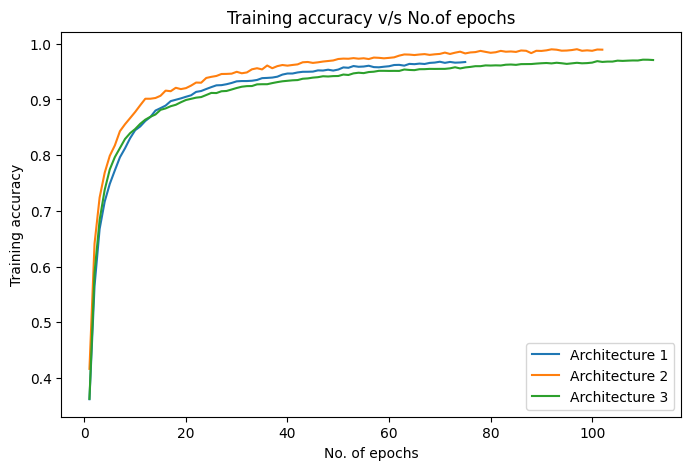

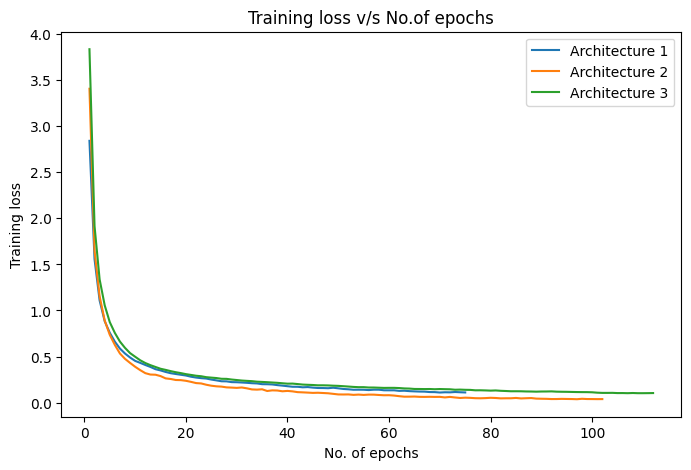

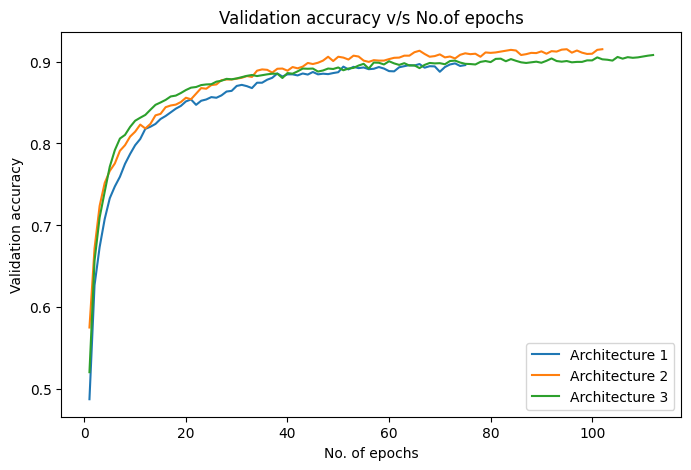

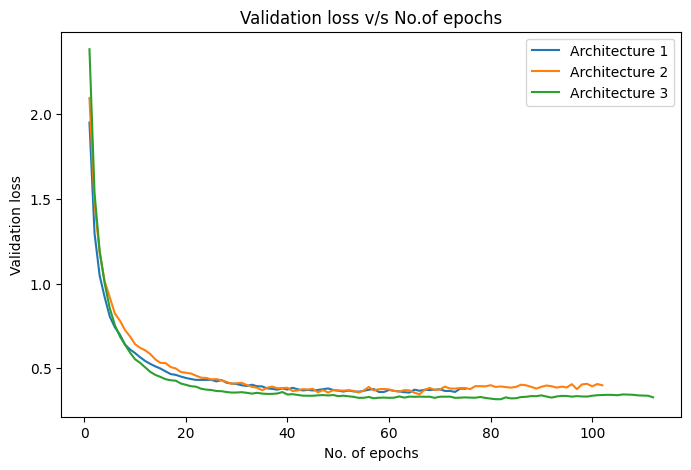


Performance of the best model for 32 dimesional test data
119/119 [==============================] - 0s 1ms/step - loss: 0.4005 - accuracy: 0.9125
Loss : 0.400455117225647
Accuracy : 0.9125164747238159
Mean squared error : tf.Tensor(0.028524855, shape=(), dtype=float32)


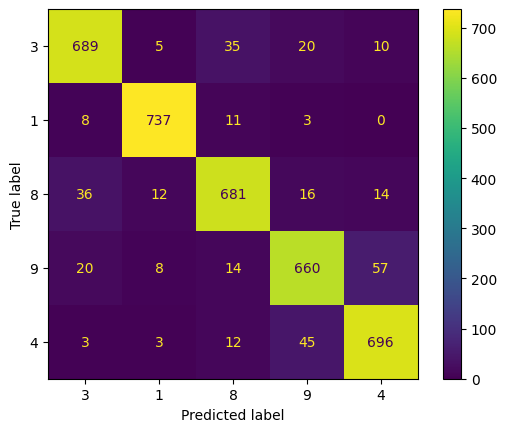

In [ ]:
compare(results_32)  # comparing the different models
# on the basis of validation accuracy architecture 2 is the best architecture
# results for test data
print("Performance of the best model for 32 dimesional test data")
prediction(models_32[1],test_pca[0],test_target)

64 dimensional data

In [ ]:
# FCNN models for 64 dimension data
models_64=[]
results_64=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[84,32]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],64,5)
  model,results=train_model(model,train_pca[1],train_target,val_pca[1],val_target)
  models_64.append(model)
  results_64.append(results)
  print("Architechure",i+1,"for 64 dimension data")
  print(model.summary())
  FCNN_performance(results)

Architechure 1 for 64 dimension data
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 150)               9750      
                                                                 
 dense_71 (Dense)            (None, 72)                10872     
                                                                 
 dense_72 (Dense)            (None, 16)                1168      
                                                                 
 dense_73 (Dense)            (None, 5)                 85        
                                                                 
Total params: 21,875
Trainable params: 21,875
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 72
Training accuracy : 96.69153094291687
Validation accuracy : 87.99476027488708
Training loss : 0.10909949988126755
Validation lo

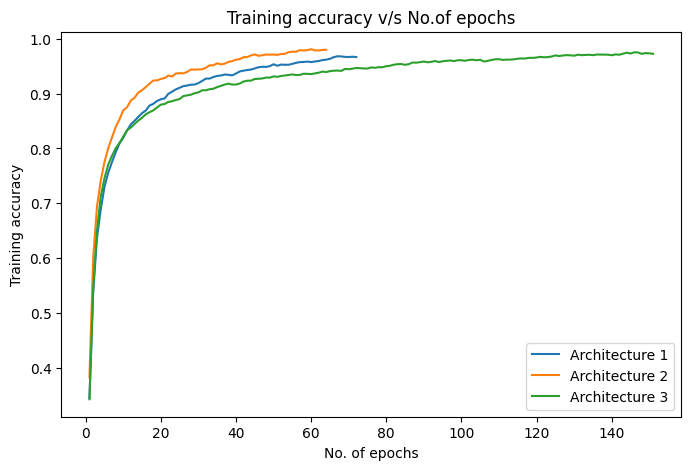

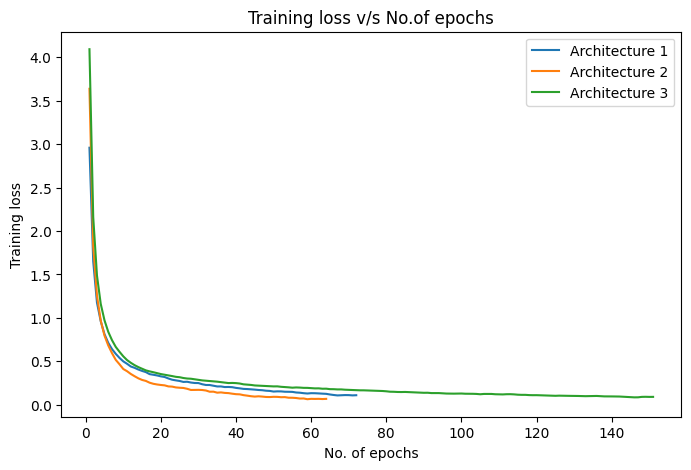

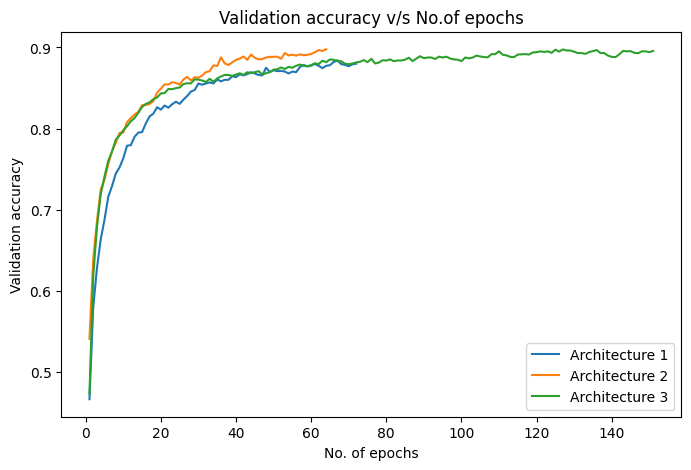

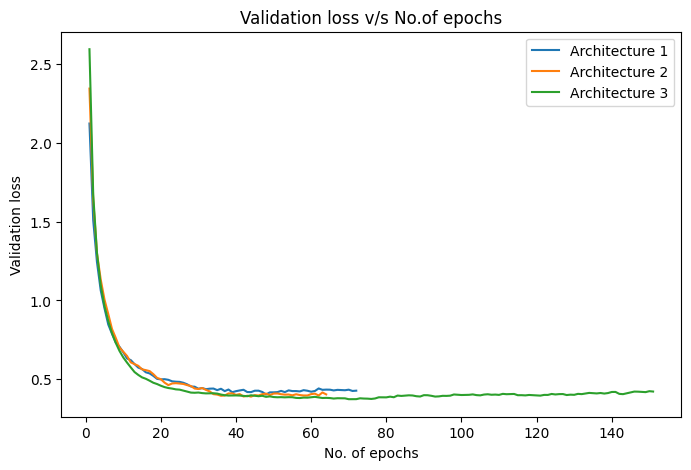


Performance of the best model for 64 dimesional test data
119/119 [==============================] - 0s 2ms/step - loss: 0.4100 - accuracy: 0.8943
Loss : 0.40997767448425293
Accuracy : 0.8943346738815308
Mean squared error : tf.Tensor(0.033779297, shape=(), dtype=float32)


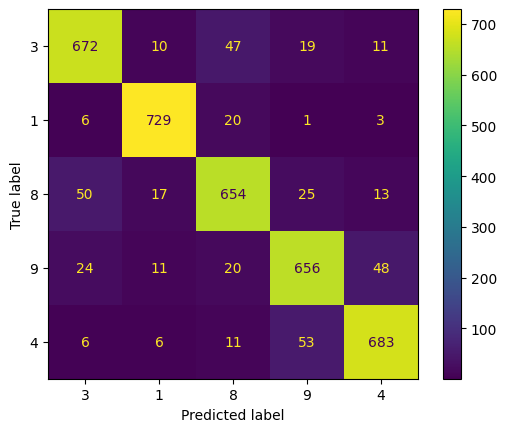

In [ ]:
compare(results_64)  # comparing the different models
# on the basis of validation accuracy architecture 2 is the best architecture
# results for test data
print("Performance of the best model for 64 dimesional test data")
prediction(models_64[1],test_pca[1],test_target)

128 dimensional data

In [ ]:
models_128=[]
results_128=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[180,40]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],128,5)
  model,results=train_model(model,train_pca[2],train_target,val_pca[2],val_target)
  models_128.append(model)
  results_128.append(results)
  print("Architechure",i+1,"for 128 dimension data")
  print(model.summary())
  FCNN_performance(results)

Architechure 1 for 128 dimension data
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 150)               19350     
                                                                 
 dense_82 (Dense)            (None, 72)                10872     
                                                                 
 dense_83 (Dense)            (None, 16)                1168      
                                                                 
 dense_84 (Dense)            (None, 5)                 85        
                                                                 
Total params: 31,475
Trainable params: 31,475
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 92
Training accuracy : 97.10399508476257
Validation accuracy : 87.41808533668518
Training loss : 0.09416303783655167
Validation l

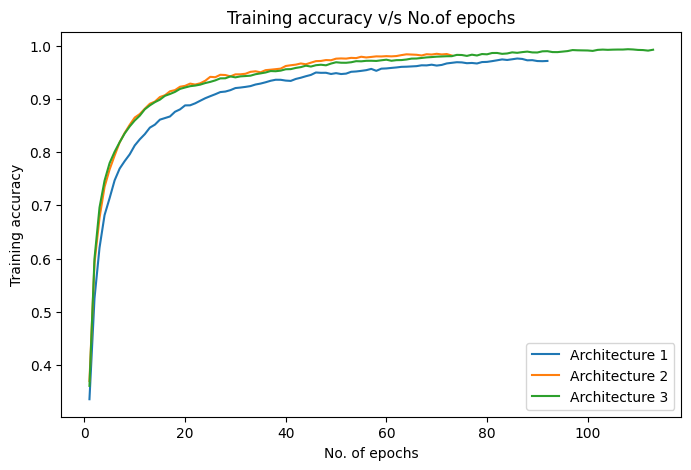

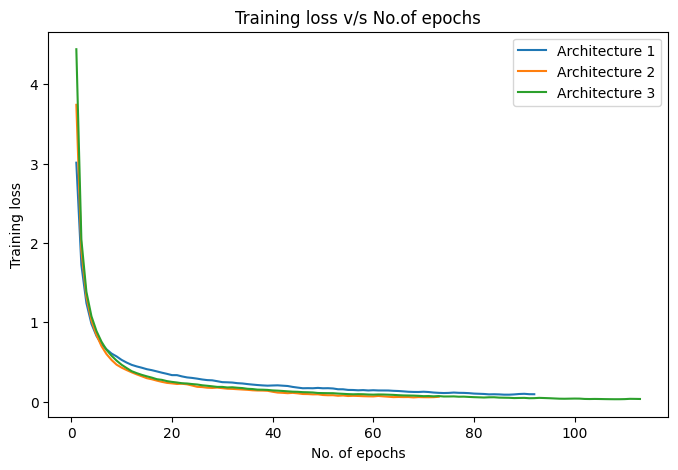

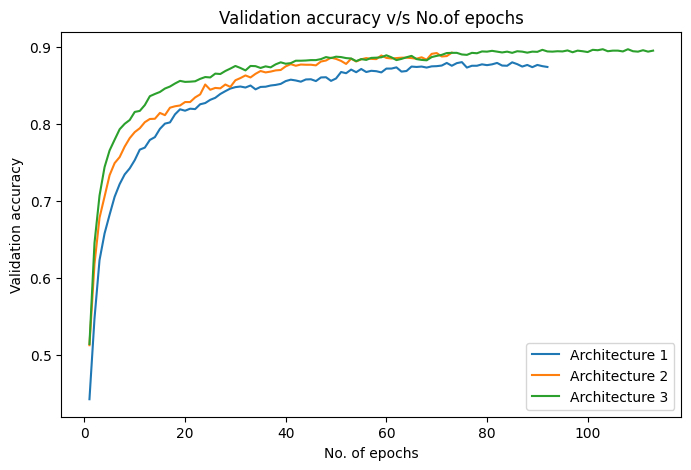

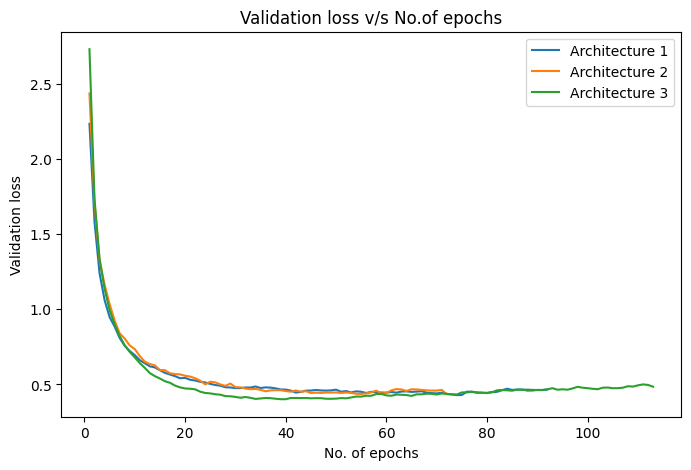


Performance of the best model for 128 dimesional test data
119/119 [==============================] - 0s 1ms/step - loss: 0.5387 - accuracy: 0.8967
Loss : 0.5387475490570068
Accuracy : 0.8967061638832092
Mean squared error : tf.Tensor(0.035310008, shape=(), dtype=float32)


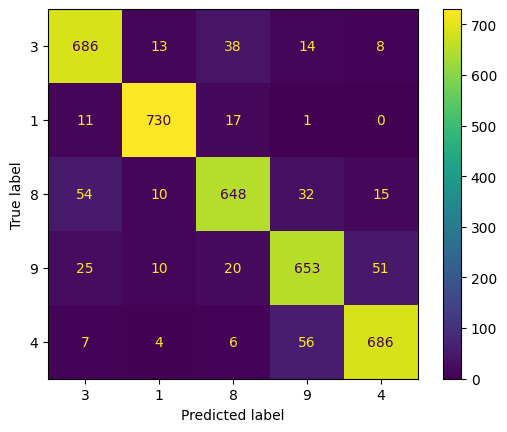

In [ ]:
compare(results_128)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 128 dimesional test data")
prediction(models_128[2],test_pca[2],test_target)

256 dimensional data

In [ ]:
models_256=[]
results_256=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[256,56]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],256,5)
  model,results=train_model(model,train_pca[3],train_target,val_pca[3],val_target)
  models_256.append(model)
  results_256.append(results)
  print("Architechure",i+1,"for 256 dimension data")
  print(model.summary())
  FCNN_performance(results)

Architechure 1 for 256 dimension data
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 150)               38550     
                                                                 
 dense_104 (Dense)           (None, 72)                10872     
                                                                 
 dense_105 (Dense)           (None, 16)                1168      
                                                                 
 dense_106 (Dense)           (None, 5)                 85        
                                                                 
Total params: 50,675
Trainable params: 50,675
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 79
Training accuracy : 96.51601314544678
Validation accuracy : 86.5530788898468
Training loss : 0.11118420213460922
Validation lo

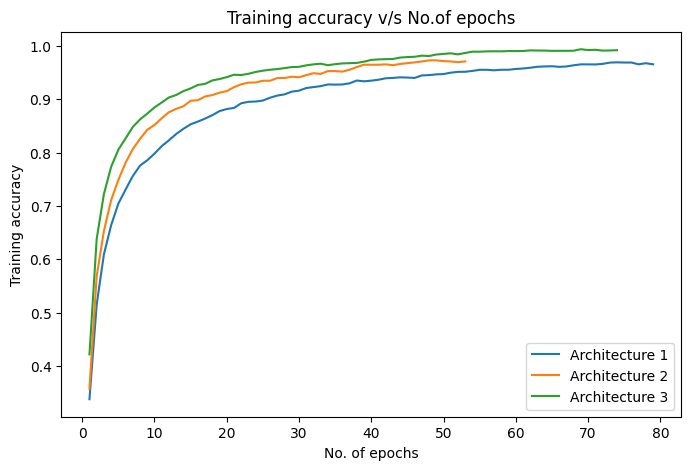

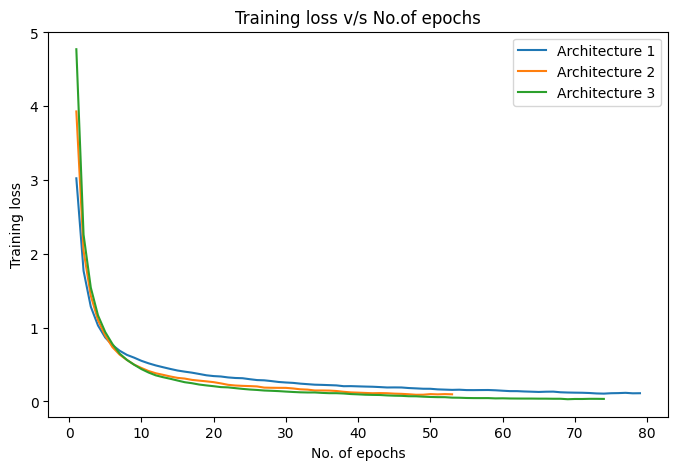

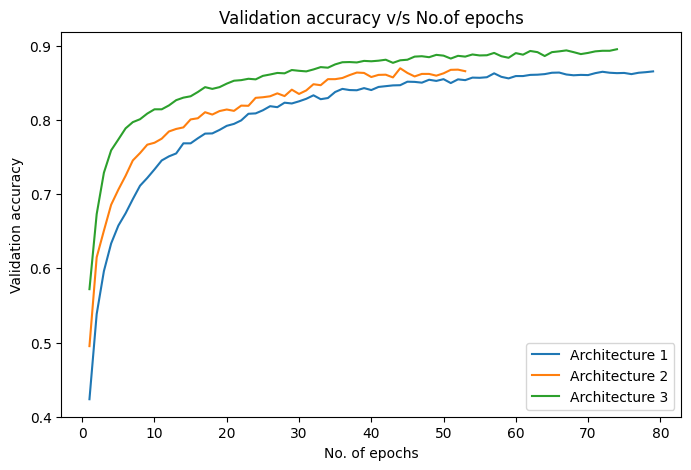

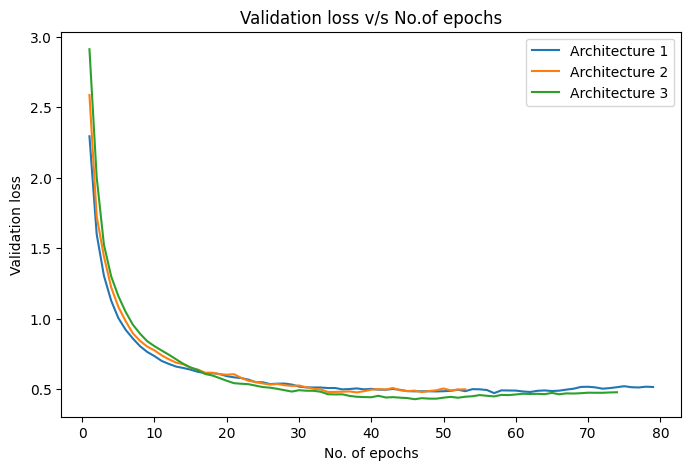


Performance of the best model for 256 dimesional test data
119/119 [==============================] - 0s 1ms/step - loss: 0.5309 - accuracy: 0.8880
Loss : 0.5309078097343445
Accuracy : 0.888010561466217
Mean squared error : tf.Tensor(0.03705598, shape=(), dtype=float32)


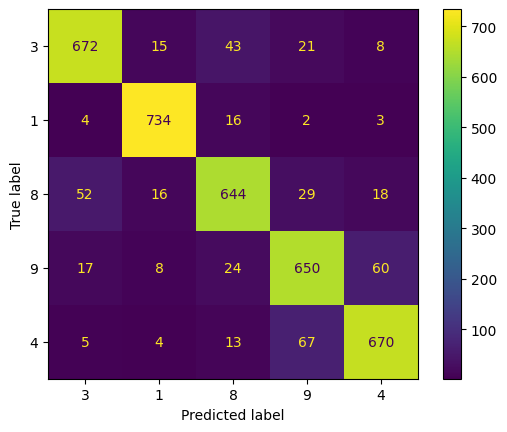

In [ ]:
compare(results_256)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 256 dimesional test data")
prediction(models_256[2],test_pca[3],test_target)

# Task 2: Building Autoencoders and image reconstruction

In [17]:
# Autoencoder class
class Autoencoder(Model):
    def __init__(self, input_dim, hidden_layers: list, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder, self.decoder = self._build(input_dim, hidden_layers, bottleneck_dim)

    def _build(self,input_dim, hidden_layers: list, bottleneck_dim):
        # Build encoder
        encoder = tf.keras.Sequential()
        encoder.add(tf.keras.Input(shape=(input_dim,)))
        for layers in hidden_layers:
            encoder.add(Dense(layers, activation = 'sigmoid'))
        encoder.add(Dense(bottleneck_dim, activation = 'sigmoid'))

        # Build Decoder
        decoder = tf.keras.Sequential()
        decoder.add(tf.keras.Input(shape=(bottleneck_dim,)))
        for layers in reversed(hidden_layers):
            decoder.add(Dense(layers, activation = 'sigmoid'))
        decoder.add(Dense(input_dim, activation = 'sigmoid'))

        return encoder, decoder

    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

    def reconstruct_one(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

def train(model,inputs_train,inputs_val) :
    epcs =1000
    # compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-07), loss = 'mse')

    # specifying callbacks
    custom_early_stopping = EarlyStopping(monitor='loss',  patience=3, mode='min', min_delta=1e-04, verbose=0)
    call_backs = [custom_early_stopping]

    # fiting to model and return train histories
    return model,model.fit(inputs_train, inputs_train, batch_size=32, epochs=epcs,
                              callbacks = call_backs, validation_data = ( inputs_val, inputs_val), verbose=0, shuffle = True)

def autoencoder_performance(model,results) :
  print(model.encoder.summary())
  print(model.decoder.summary())
  print("Epochs :",len(results.history['loss']))
  print("Training loss :",results.history['loss'][-1])
  print("Validation loss :",results.history['val_loss'][-1])
  print()
  print()


1 hidden layer autoencoders

In [18]:
h1_layer_models=[]
h1_layer_results=[]

for bottleneck in [32,64,128,256] :
  print("Autoencoder with ",bottleneck," dimension bottleneck layer")
  auto=Autoencoder(784,[],bottleneck)
  auto,results=train(auto,train_ip,val_ip)
  h1_layer_models.append(auto)
  h1_layer_results.append(results)
  autoencoder_performance(auto,results)

Autoencoder with  32  dimension bottleneck layer
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                25120     
                                                                 
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 19
Training loss : 6645.8408203125
Validation loss : 6673.0791015625


Autoencoder with  6

In [ ]:
  # image reconstruction
def reconstruct(img,models):
    fig = plt.figure(figsize=(10, 5))
    #fig.suptitle("Image Reconstruction- 1 Hidden Layers")
    fig.subplots_adjust(hspace=0.4, top=0.85)

    i = 1
    for j in range(len(models)):
        out = models[j].reconstruct_one(img)
        reconstruct_img = np.reshape(out, [28, 28,1]).astype('float')*255.0
        orig_image = np.reshape(img, [28, 28,1])*255.0

        ax = fig.add_subplot(2, 4, i)
        ax.imshow(orig_image, cmap="gray")
        ax.set_title("Original "+str(j+1))

        ax = fig.add_subplot(2, 4, i+4)
        ax.imshow(reconstruct_img, cmap="gray")
        ax.set_title("Reconstructed "+str(j+1))
        i += 1

    plt.show()

def dataset_reconstruct(input,target,models) :
    for c in range(len(classes)):
        # Get the indices of all the samples in the test set that belong to class c
        indices = np.where(target[:, c] == 1)[0]
        # Set the random state to ensure reproducibility
        np.random.seed(42)
        index = np.random.choice(indices)
        image = input[index]
        image= tf.expand_dims(image, axis=0)
        reconstruct(image,models)
    print()

In [ ]:
dataset_reconstruct(train_ip,train_target,h1_layer_models)
dataset_reconstruct(val_ip,val_target,h1_layer_models)
dataset_reconstruct(test_ip,test_target,h1_layer_models)

3 hidden layer autoencoders

In [ ]:
h3_layer_models=[]
h3_layer_results=[]

for bottleneck in [32,64,128,256] :
  print("Autoencoder with ",bottleneck," dimension bottleneck layer")
  auto=Autoencoder(784,[400],bottleneck)
  auto,results=train(auto,train_ip,val_ip)
  h3_layer_models.append(auto)
  h3_layer_results.append(results)
  autoencoder_performance(auto,results)

Autoencoder with  32  dimension bottleneck layer
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 400)               314000    
                                                                 
 dense_64 (Dense)            (None, 32)                12832     
                                                                 
Total params: 326,832
Trainable params: 326,832
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 400)               13200     
                                                                 
 dense_66 (Dense)            (None, 784)               314384    
                                    

In [ ]:
dataset_reconstruct(train_ip,train_target,h3_layer_models)
dataset_reconstruct(val_ip,val_target,h3_layer_models)
dataset_reconstruct(test_ip,test_target,h3_layer_models)

Reconstruction errors

In [ ]:
def get_reconstruction_error(y_true, y_pred):
     mse = tf.keras.losses.MeanSquaredError()
     return round(mse(y_true, y_pred).numpy(),3)

def recon_error(bottleneck,model,input,dataset) :
  errors =[]
  for i in range(len(bottleneck)):
    preds = model[i].reconstruct_one(input)
    err = get_reconstruction_error(input,preds)
    errors.append(err)

  fig=plt.figure(figsize=(5,4))
  plt.bar(['32','64','128','256'],errors,color='olive',width=0.7)
  plt.ylabel("Average reconstructio error",fontsize=8)
  plt.xlabel("Neurons in bottleneck",fontsize=8)
  plt.title("Average reconstructio error v/s Neurons in bottleneck ("+dataset+")",fontsize=10)
  plt.show()

In [ ]:
# 1 hidden layer
recon_error([32,64,128,256],h1_layer_models,train_ip,"Training")
recon_error([32,64,128,256],h1_layer_models,val_ip,"Validation")
recon_error([32,64,128,256],h1_layer_models,test_ip,"Test")

In [ ]:
# 3 hidden layer
recon_error([32,64,128,256],h3_layer_models,train_ip,"Training")
recon_error([32,64,128,256],h3_layer_models,val_ip,"Validation")
recon_error([32,64,128,256],h3_layer_models,test_ip,"Test")

# Task 3: Classification on compressed data ( from 1 hidden layer autoencoder)

In [ ]:
# get compressed representations
compressed_train=[]
compressed_val=[]
compressed_test=[]
bottleneck=[32,64,128,256]

for i in range(len(bottleneck)) :
  data=np.array(h1_layer_models[i].encoder(train_ip))
  compressed_train.append(data)

for i in range(len(bottleneck)) :
  data=np.array(h1_layer_models[i].encoder(val_ip))
  compressed_val.append(data)

for i in range(len(bottleneck)) :
  data=np.array(h1_layer_models[i].encoder(test_ip))
  compressed_test.append(data)

Making models

32 dimension

In [ ]:
models_32=[]
results_32=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[84,32]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],32,5)
  model,results=train_model(model,compressed_train[0],train_target,compressed_val[0],val_target)
  models_32.append(model)
  results_32.append(results)
  print("Architechure",i+1,"for 32 dimension data")
  print(model.summary())
  FCNN_performance(results)

In [ ]:
compare(results_32)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 32 dimesional test data")
prediction(models_32[2],compressed_test[0],test_target)

64 dimension

In [ ]:
models_64=[]
results_64=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[84,32]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],64,5)
  model,results=train_model(model,compressed_train[1],train_target,compressed_val[1],val_target)
  models_64.append(model)
  results_64.append(results)
  print("Architechure",i+1,"for 64 dimension data")
  print(model.summary())
  FCNN_performance(results)

compare(results_64)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 32 dimesional test data")
prediction(models_64[2],compressed_test[1],test_target)


128 dimension

Architechure 1 for 128 dimension data
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 150)               19350     
                                                                 
 dense_42 (Dense)            (None, 72)                10872     
                                                                 
 dense_43 (Dense)            (None, 16)                1168      
                                                                 
 dense_44 (Dense)            (None, 5)                 85        
                                                                 
Total params: 31,475
Trainable params: 31,475
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 123
Training accuracy : 86.11671924591064
Validation accuracy : 82.07077383995056
Training loss : 0.39000657200813293
Validation 

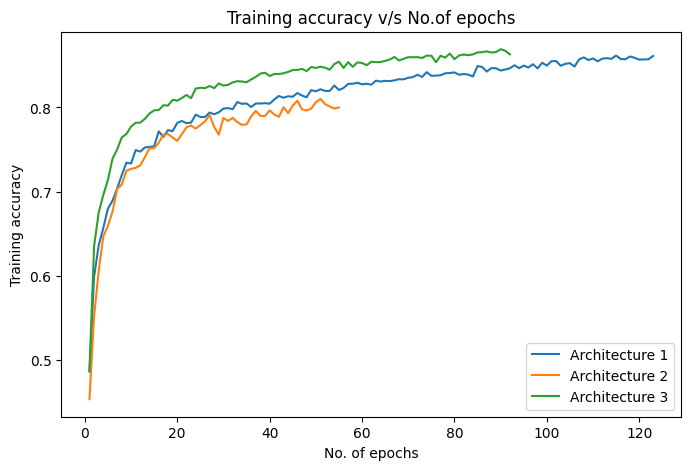

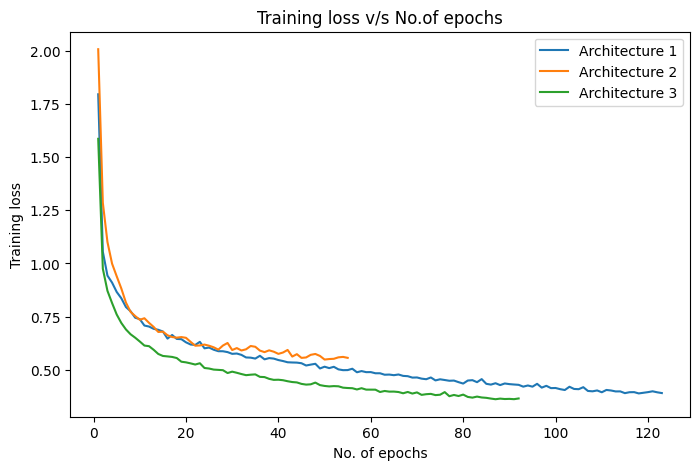

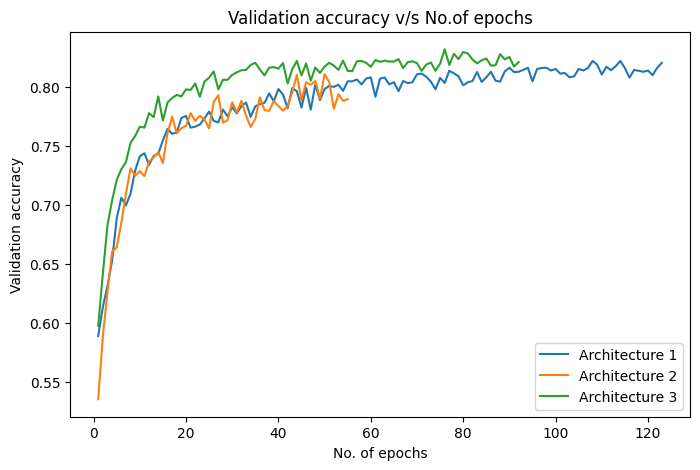

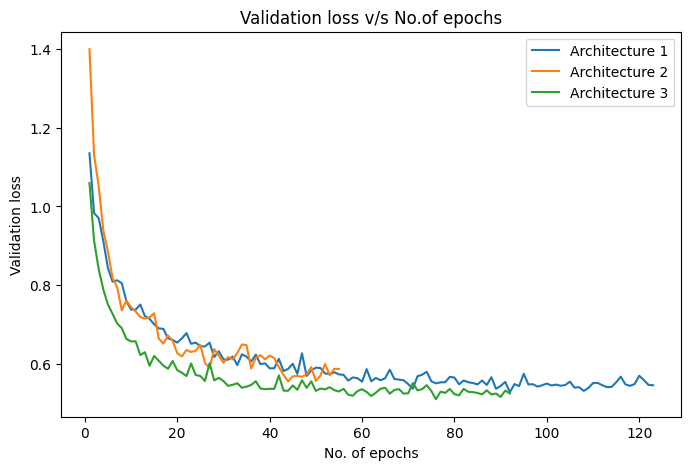


Performance of the best model for 128 dimesional test data
119/119 [==============================] - 0s 2ms/step - loss: 0.5209 - accuracy: 0.8250
Loss : 0.5209484696388245
Accuracy : 0.8250329494476318
Mean squared error : tf.Tensor(0.05184713, shape=(), dtype=float32)


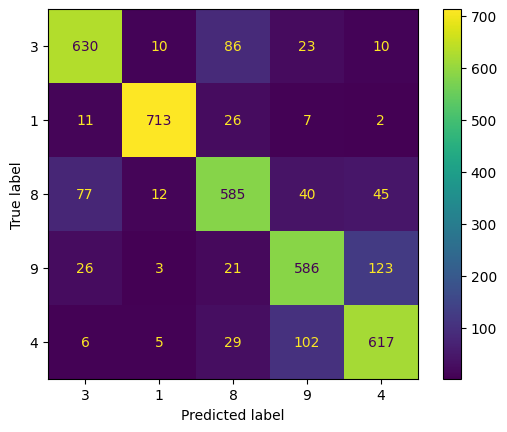

In [ ]:
models_128=[]
results_128=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[180,40]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],128,5)
  model,results=train_model(model,compressed_train[2],train_target,compressed_val[2],val_target)
  models_128.append(model)
  results_128.append(results)
  print("Architechure",i+1,"for 128 dimension data")
  print(model.summary())
  FCNN_performance(results)

compare(results_128)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 128 dimesional test data")
prediction(models_128[2],compressed_test[2],test_target)

256 dimension

Architechure 1 for 256 dimension data
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 150)               38550     
                                                                 
 dense_53 (Dense)            (None, 72)                10872     
                                                                 
 dense_54 (Dense)            (None, 16)                1168      
                                                                 
 dense_55 (Dense)            (None, 5)                 85        
                                                                 
Total params: 50,675
Trainable params: 50,675
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 54
Training accuracy : 87.24879622459412
Validation accuracy : 86.89383864402771
Training loss : 0.3971902132034302
Validation lo

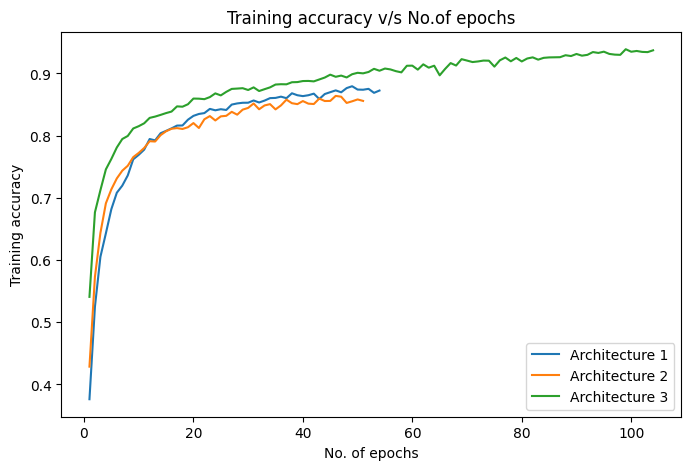

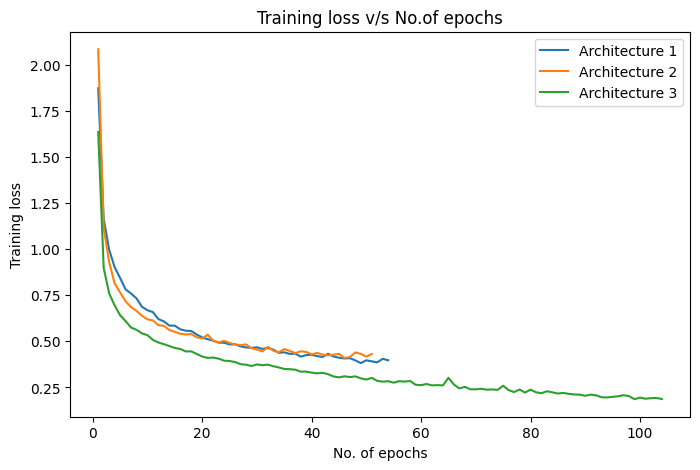

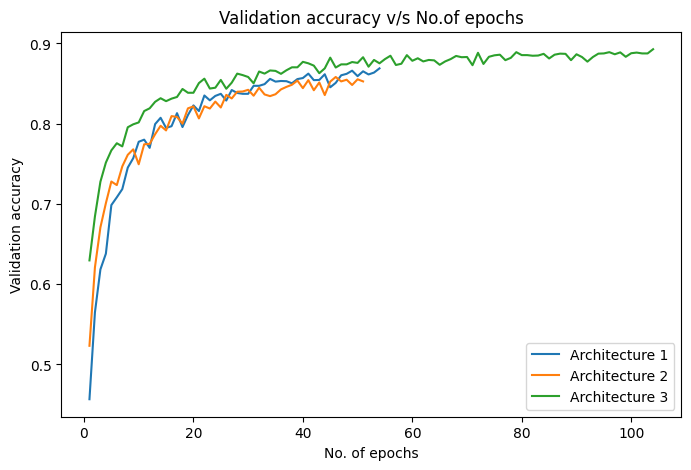

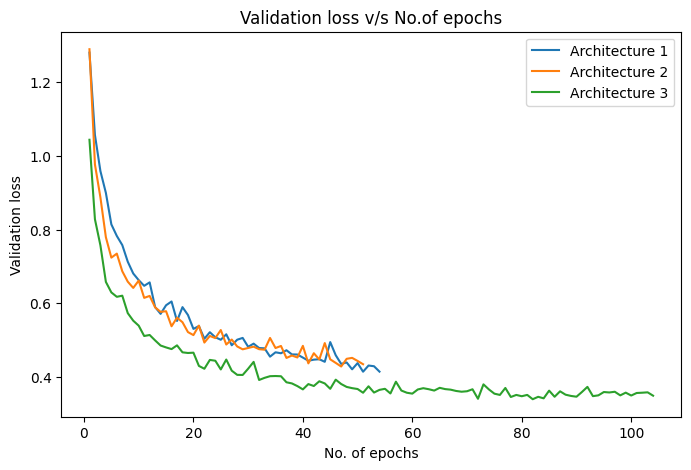


Performance of the best model for 256 dimesional test data


ValueError: ignored

In [ ]:
models_256=[]
results_256=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[256,56]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],256,5)
  model,results=train_model(model,compressed_train[3],train_target,compressed_val[3],val_target)
  models_256.append(model)
  results_256.append(results)
  print("Architechure",i+1,"for 256 dimension data")
  print(model.summary())
  FCNN_performance(results)


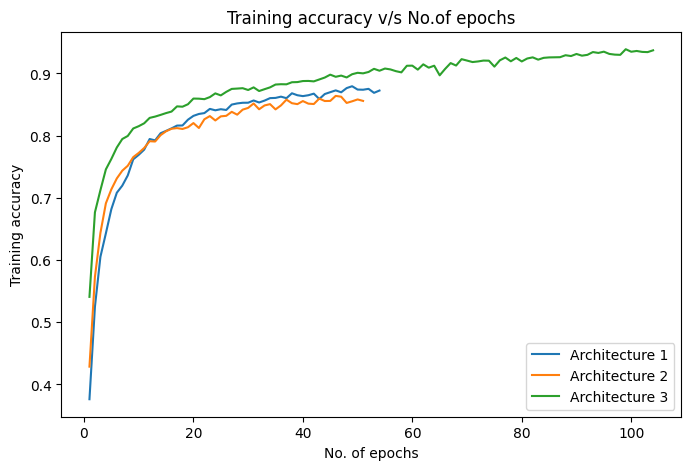

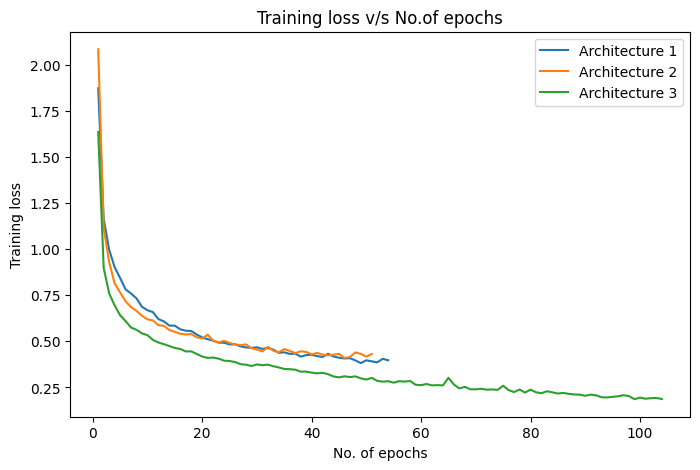

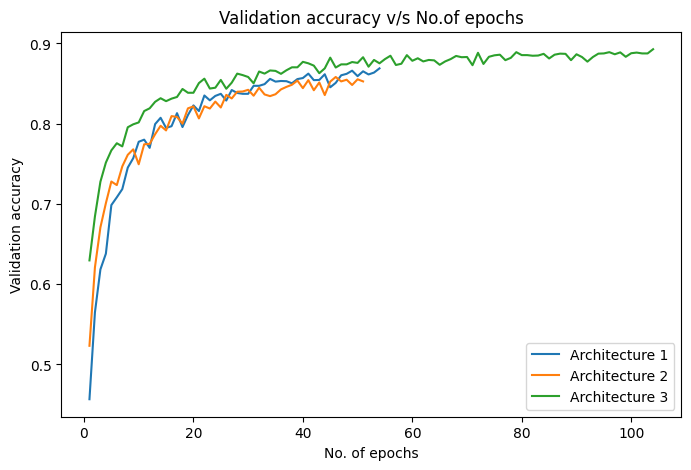

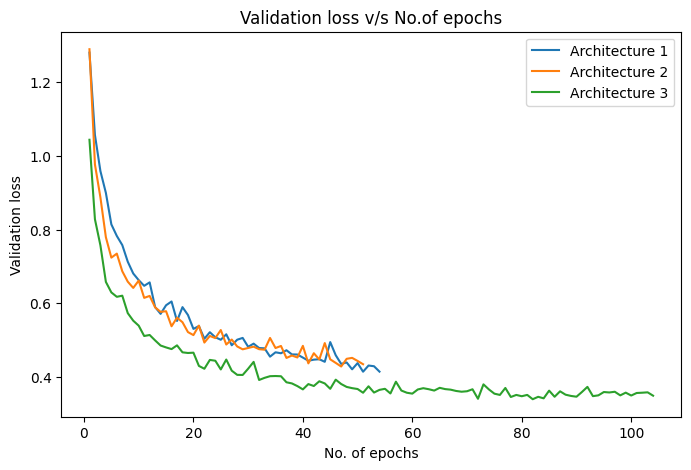


Performance of the best model for 256 dimesional test data
119/119 [==============================] - 0s 2ms/step - loss: 0.4439 - accuracy: 0.8469
Loss : 0.4438771903514862
Accuracy : 0.8469038009643555
Mean squared error : tf.Tensor(0.044375602, shape=(), dtype=float32)


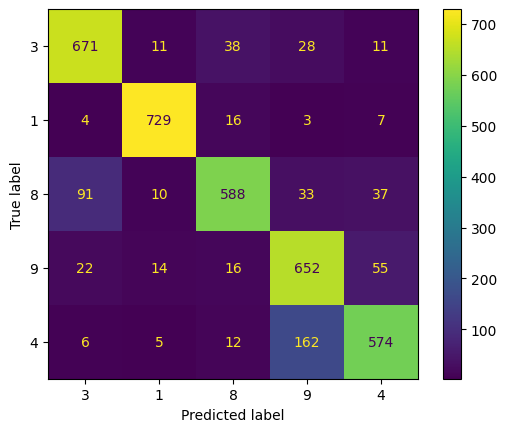

In [ ]:
compare(results_256)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 256 dimesional test data")
prediction(models_256[1],compressed_test[3],test_target)

# Task 4: Classification on compressed data ( from 3 hidden layer autoencoder)

In [ ]:
# get compressed representations
compressed_train=[]
compressed_val=[]
compressed_test=[]
bottleneck=[32,64,128,256]

for i in range(len(bottleneck)) :
  data=np.array(h3_layer_models[i].encoder(train_ip))
  compressed_train.append(data)

for i in range(len(bottleneck)) :
  data=np.array(h3_layer_models[i].encoder(val_ip))
  compressed_val.append(data)

for i in range(len(bottleneck)) :
  data=np.array(h3_layer_models[i].encoder(test_ip))
  compressed_test.append(data)

making models

32 dimension

In [ ]:
models_32=[]
results_32=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[84,32]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],32,5)
  model,results=train_model(model,compressed_train[0],train_target,compressed_val[0],val_target)
  models_32.append(model)
  results_32.append(results)
  print("Architechure",i+1,"for 32 dimension data")
  print(model.summary())
  FCNN_performance(results)

compare(results_32)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 32 dimesional test data")
prediction(models_32[2],compressed_test[0],test_target)

64 dimension

In [ ]:
models_64=[]
results_64=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[84,32]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],64,5)
  model,results=train_model(model,compressed_train[1],train_target,compressed_val[1],val_target)
  models_64.append(model)
  results_64.append(results)
  print("Architechure",i+1,"for 64 dimension data")
  print(model.summary())
  FCNN_performance(results)

compare(results_64)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 32 dimesional test data")
prediction(models_64[2],compressed_test[1],test_target)


128 dimension

Architechure 1 for 128 dimension data
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_101 (Dense)           (None, 150)               19350     
                                                                 
 dense_102 (Dense)           (None, 72)                10872     
                                                                 
 dense_103 (Dense)           (None, 16)                1168      
                                                                 
 dense_104 (Dense)           (None, 5)                 85        
                                                                 
Total params: 31,475
Trainable params: 31,475
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 12
Training accuracy : 37.13032007217407
Validation accuracy : 33.4993451833725
Training loss : 1.4141863584518433
Validation los

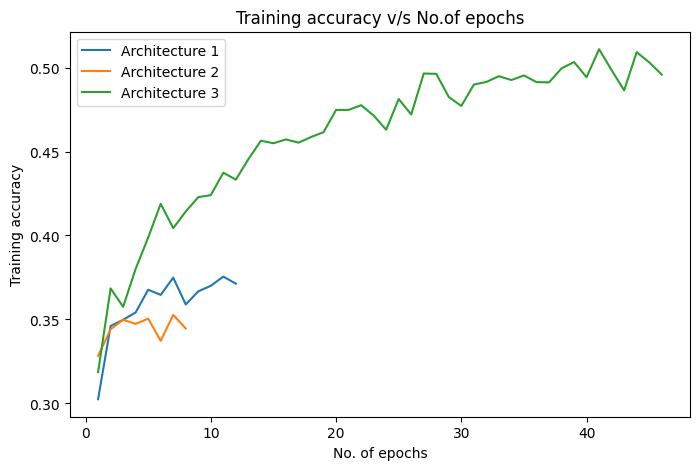

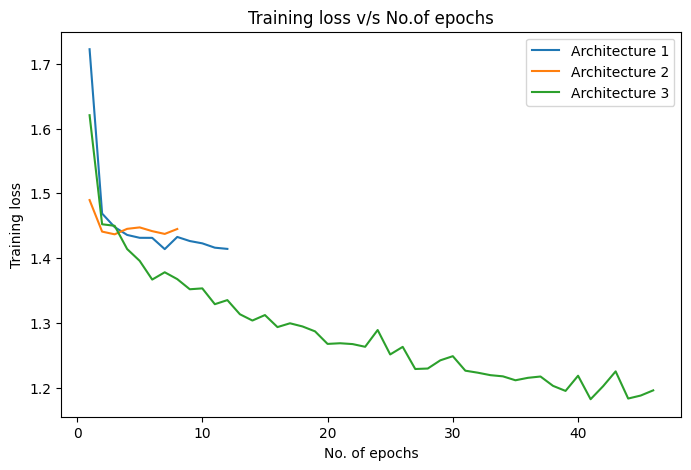

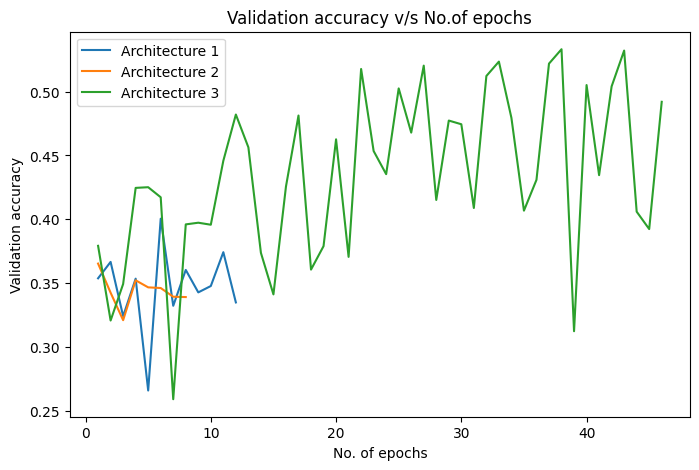

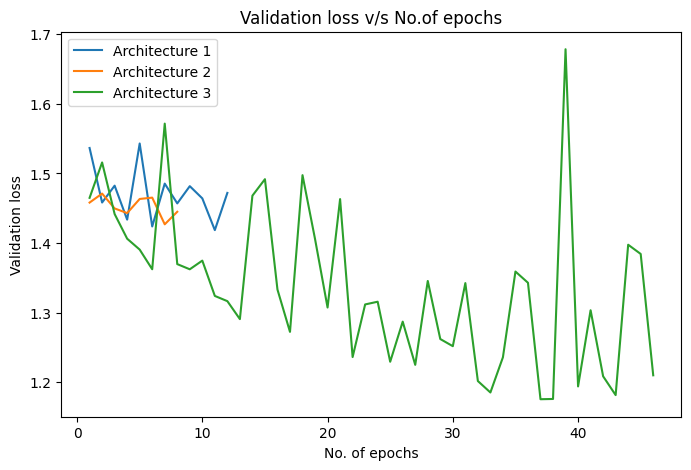


Performance of the best model for 128 dimesional test data
119/119 [==============================] - 0s 2ms/step - loss: 1.1856 - accuracy: 0.5036
Loss : 1.1856063604354858
Accuracy : 0.5035573244094849
Mean squared error : tf.Tensor(0.123385474, shape=(), dtype=float32)


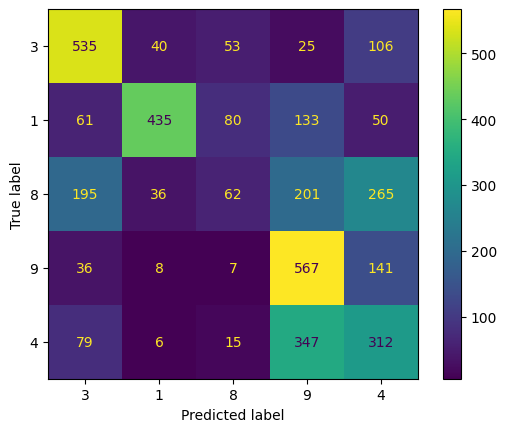

In [ ]:
models_128=[]
results_128=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[180,40]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],128,5)
  model,results=train_model(model,compressed_train[2],train_target,compressed_val[2],val_target)
  models_128.append(model)
  results_128.append(results)
  print("Architechure",i+1,"for 128 dimension data")
  print(model.summary())
  FCNN_performance(results)

compare(results_128)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 128 dimesional test data")
prediction(models_128[2],compressed_test[2],test_target)

256 dimension

Architechure 1 for 256 dimension data
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 150)               38550     
                                                                 
 dense_113 (Dense)           (None, 72)                10872     
                                                                 
 dense_114 (Dense)           (None, 16)                1168      
                                                                 
 dense_115 (Dense)           (None, 5)                 85        
                                                                 
Total params: 50,675
Trainable params: 50,675
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 50
Training accuracy : 60.26327610015869
Validation accuracy : 62.17561960220337
Training loss : 0.9497835040092468
Validation lo

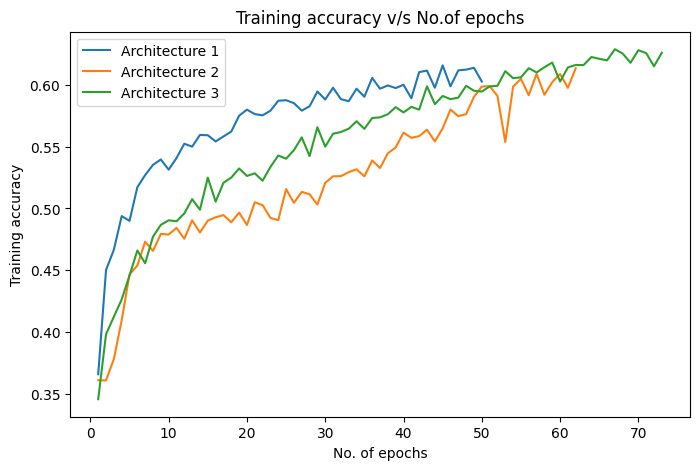

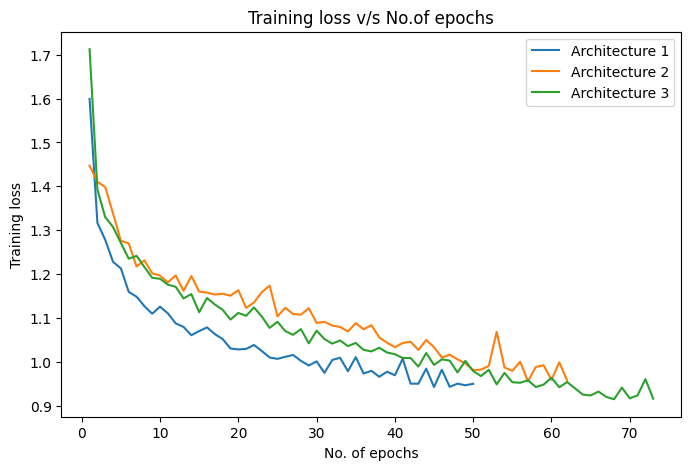

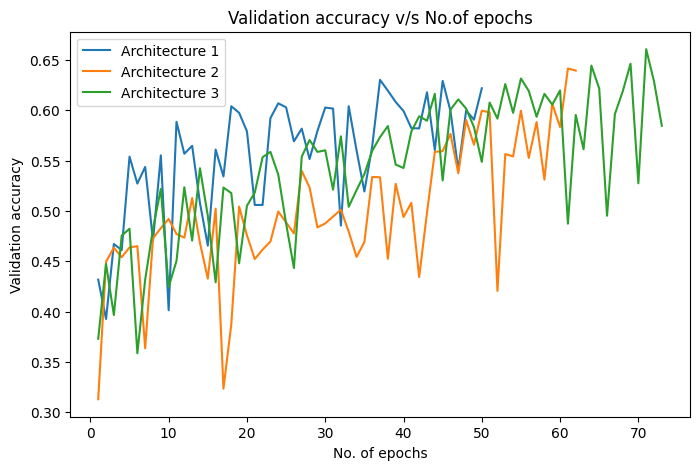

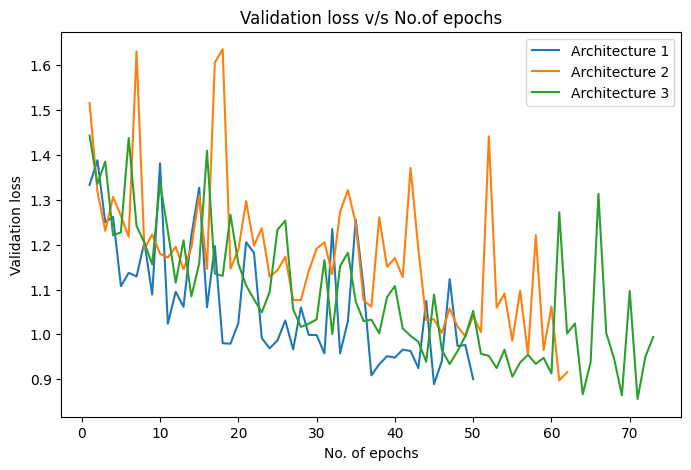


Performance of the best model for 256 dimesional test data
119/119 [==============================] - 0s 2ms/step - loss: 0.9152 - accuracy: 0.6337
Loss : 0.9151834845542908
Accuracy : 0.633728563785553
Mean squared error : tf.Tensor(0.09745192, shape=(), dtype=float32)


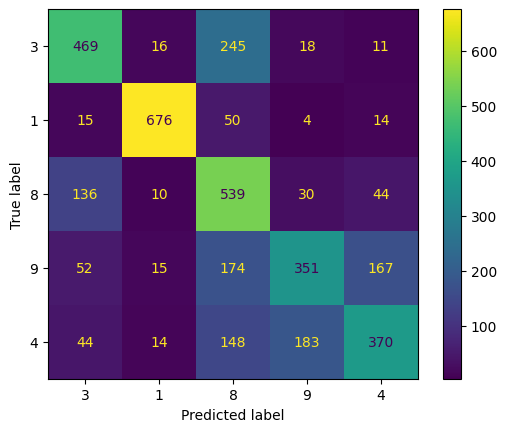

In [ ]:
models_256=[]
results_256=[]
hidden_layer_arch=[[150,72,16],[256,128,30],[256,56]]
for i in range(len(hidden_layer_arch)) :
  model=build_FCNN(hidden_layer_arch[i],256,5)
  model,results=train_model(model,compressed_train[3],train_target,compressed_val[3],val_target)
  models_256.append(model)
  results_256.append(results)
  print("Architechure",i+1,"for 256 dimension data")
  print(model.summary())
  FCNN_performance(results)

compare(results_256)  # comparing the different models
# on the basis of validation accuracy architecture 3 is the best architecture
# results for test data
print("Performance of the best model for 256 dimesional test data")
prediction(models_256[1],compressed_test[3],test_target)

# Task 5 : Denoiser autoencoders

In [22]:
def train(model,inputs_train,inputs_val,noise_prob) :
    epcs =1000
    # compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-07), loss = 'mse')

    # specifying callbacks
    custom_early_stopping = EarlyStopping(monitor='loss',  patience=3, mode='min', min_delta=1e-04, verbose=0)
    call_backs = [custom_early_stopping]

    noisy_train = add_noise(inputs_train,noise_prob)
    noisy_val = add_noise(inputs_val,noise_prob)
    # fiting to model and return train histories
    return model,model.fit(noisy_train, inputs_train, batch_size=32, epochs=epcs,
                              callbacks = call_backs, validation_data = ( noisy_val, inputs_val), verbose=0, shuffle = True)

def add_noise(data,prob_noise):
      # Set the random state to ensure reproducibility
      np.random.seed(23)
      mask = np.random.normal(0,1, size = data.shape)
      mask[mask > prob_noise] = 0
      noisy_data = data + mask
      return noisy_data

In [ ]:
# image reconstruction

def reconstruct(model, imgs: list, title: str=""):
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle("Denoised Image using Autoencoder Visualization for "+title)

    i = 1
    for original, noisy in imgs:
        denoised = model.reconstruct_one(tf.expand_dims(noisy, axis=0))
        reconstruct_img = np.reshape(denoised, [28, 28,1]).astype('float')*255.0
        orig_image = np.reshape(original, [28, 28,1])*255.0
        noisy_image = np.reshape(noisy, [28, 28,1]).astype('float')*255.0

        ax = fig.add_subplot(3, 5, i)
        ax.imshow(orig_image, cmap="gray")
        ax.set_title("Original "+str(i))

        ax = fig.add_subplot(3, 5, i+5)
        ax.imshow(noisy_image, cmap="gray")
        ax.set_title("Noisy "+str(i))

        ax = fig.add_subplot(3, 5, i+10)
        ax.imshow(reconstruct_img, cmap="gray")
        ax.set_title("Denoised "+str(i))

        i += 1
    # using padding
    fig.tight_layout(pad=1)
    plt.show()

def random_reconstruct(model,inputs, targets, title: str=""):
    print("For "+title)
    noisy_inputs = add_noise(inputs,0.2)
    images_all_classes = []
    for c in range(5):
        indices = np.where(targets[:, c] == 1)[0]
        np.random.seed(44)
        index = np.random.choice(indices)
        images_all_classes.append((inputs[index],noisy_inputs[index]))
    return images_all_classes
   # reconstruct(images_all_classes, title)


20% noise

In [24]:
denoiser=Autoencoder(784,[],256)
denoiser,results=train(denoiser,train_ip,val_ip,0.2)
autoencoder_performance(denoiser,results)
denoiser_2=denoiser

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               200960    
                                                                 
Total params: 200,960
Trainable params: 200,960
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 784)               201488    
                                                                 
Total params: 201,488
Trainable params: 201,488
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 43
Training loss : 6645.67822265625
Validation loss : 6672.92236328125




In [ ]:
noisy_train=add_noise(train_ip,0.2)
noisy_val=add_noise(val_ip,0.2)
noisy_test=add_noise(test_ip,0.2)
denoiser_train=denoiser.encoder(train_ip)
denoiser_val=denoiser.encoder(val_ip)
denoiser_test=denoiser.encoder(test_ip)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 256)               65792     
                                                                 
 dense_130 (Dense)           (None, 128)               32896     
                                                                 
 dense_131 (Dense)           (None, 30)                3870      
                                                                 
 dense_132 (Dense)           (None, 5)                 155       
                                                                 
Total params: 102,713
Trainable params: 102,713
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 49
Training accuracy : 87.02939748764038
Validation accuracy : 86.15989685058594
Training loss : 0.4005894958972931
Validation loss : 0.40138572454452515


Performan

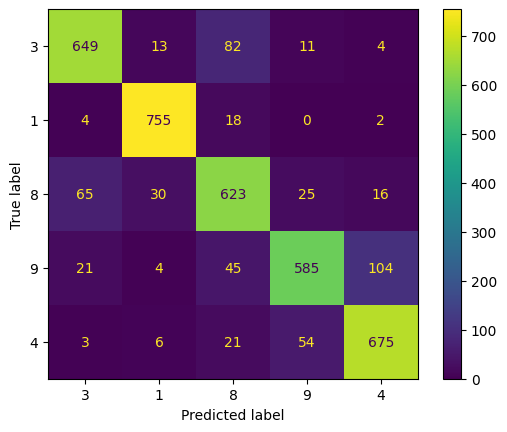

119/119 [==============================] - 0s 2ms/step - loss: 0.4103 - accuracy: 0.8714
Loss : 0.41029253602027893
Accuracy : 0.8714097738265991
Mean squared error : tf.Tensor(0.040721774, shape=(), dtype=float32)


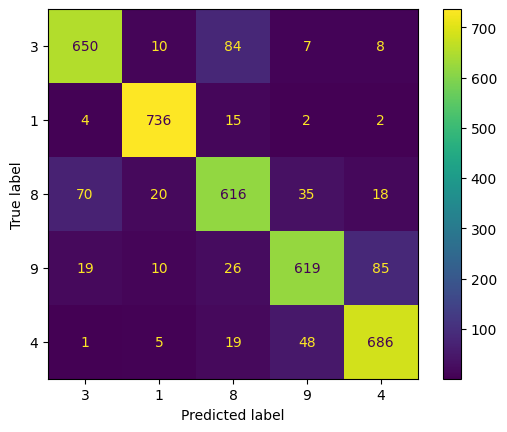

In [ ]:
hidden_layer_arch=[256,128,30]
model=build_FCNN(hidden_layer_arch,256,5)
model,results=train_model(model,denoiser_train,train_target,denoiser_val,val_target)
print(model.summary())
FCNN_performance(results)

print("Performance of the best model for 32 dimesional test data")
prediction(model,denoiser_val,val_target)
prediction(model,denoiser_test,test_target)

For Training data


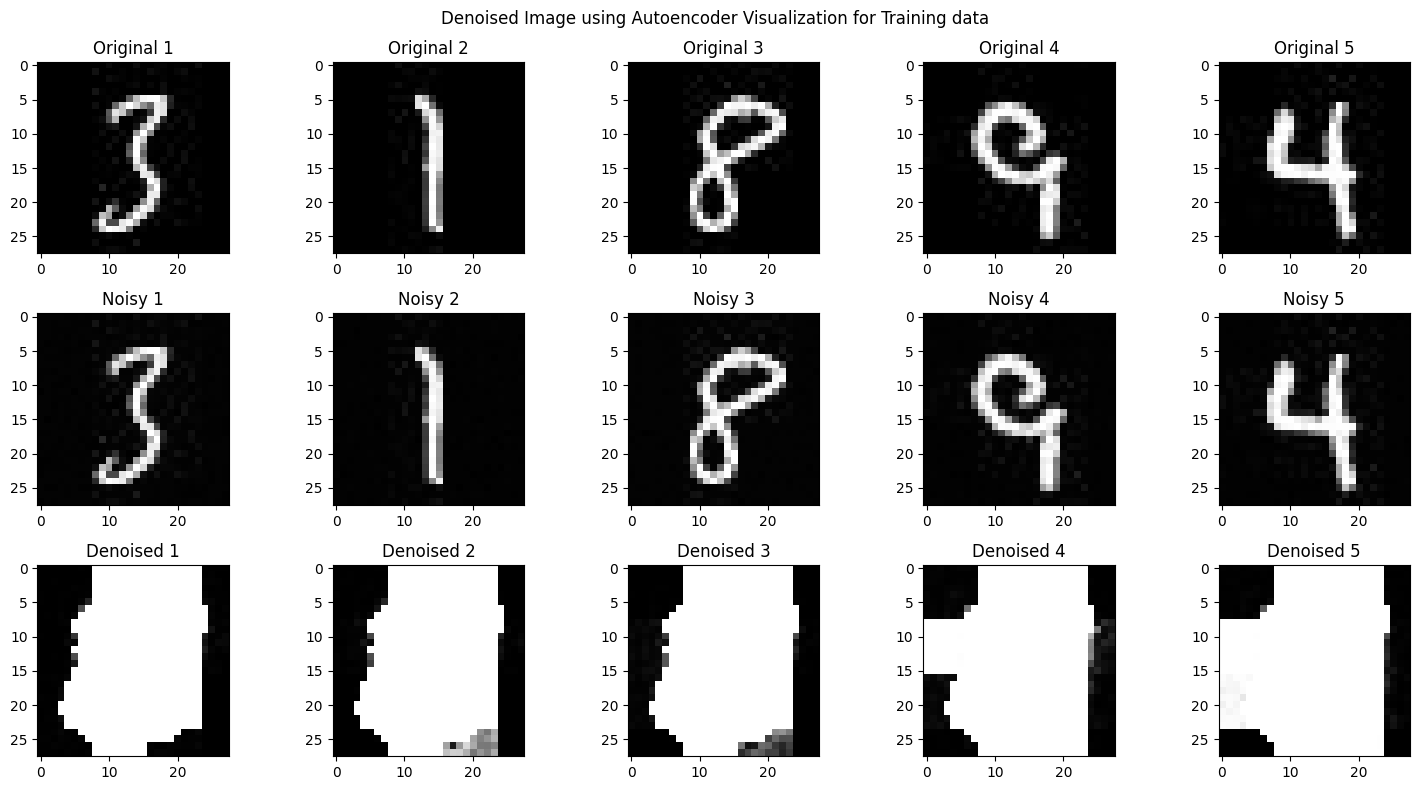

For Validation data


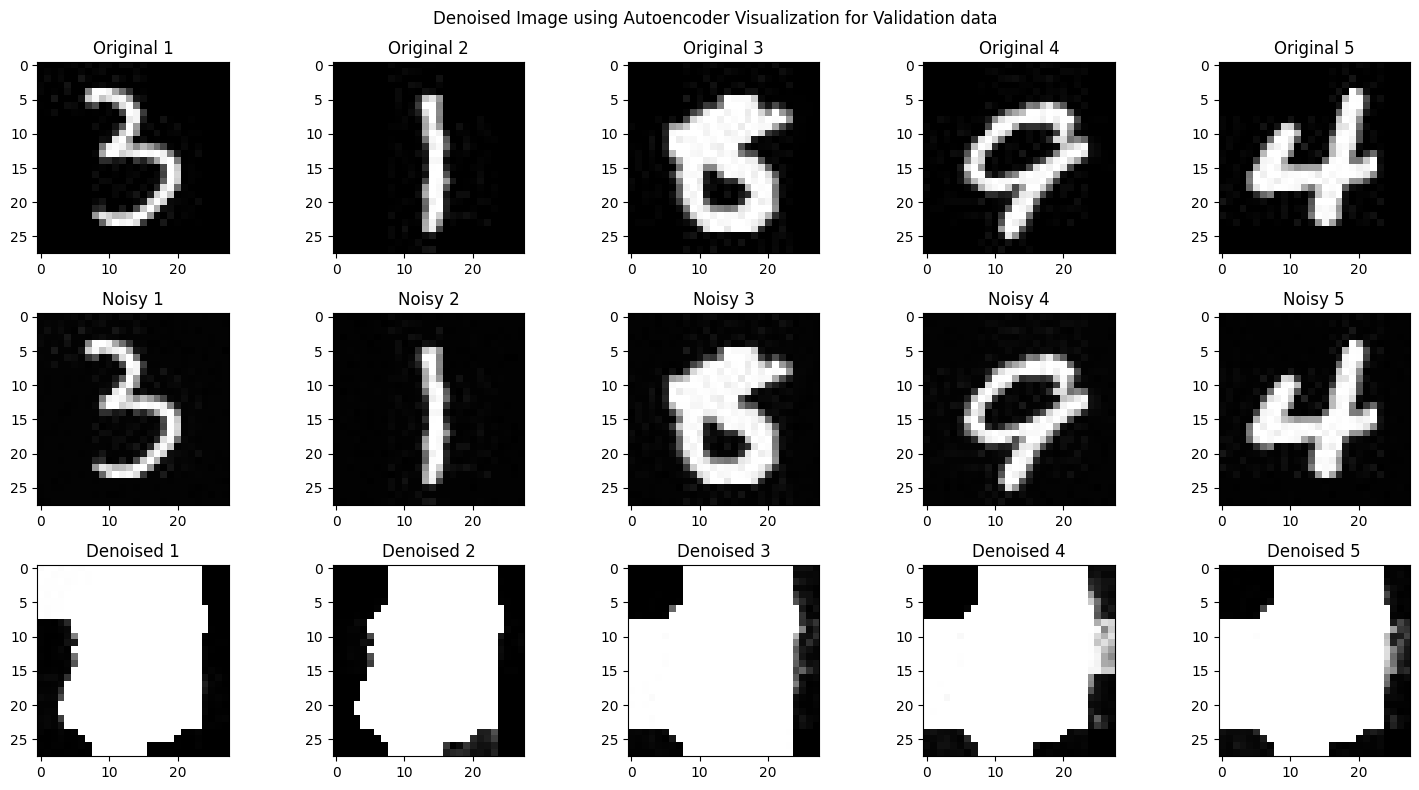

For Test data


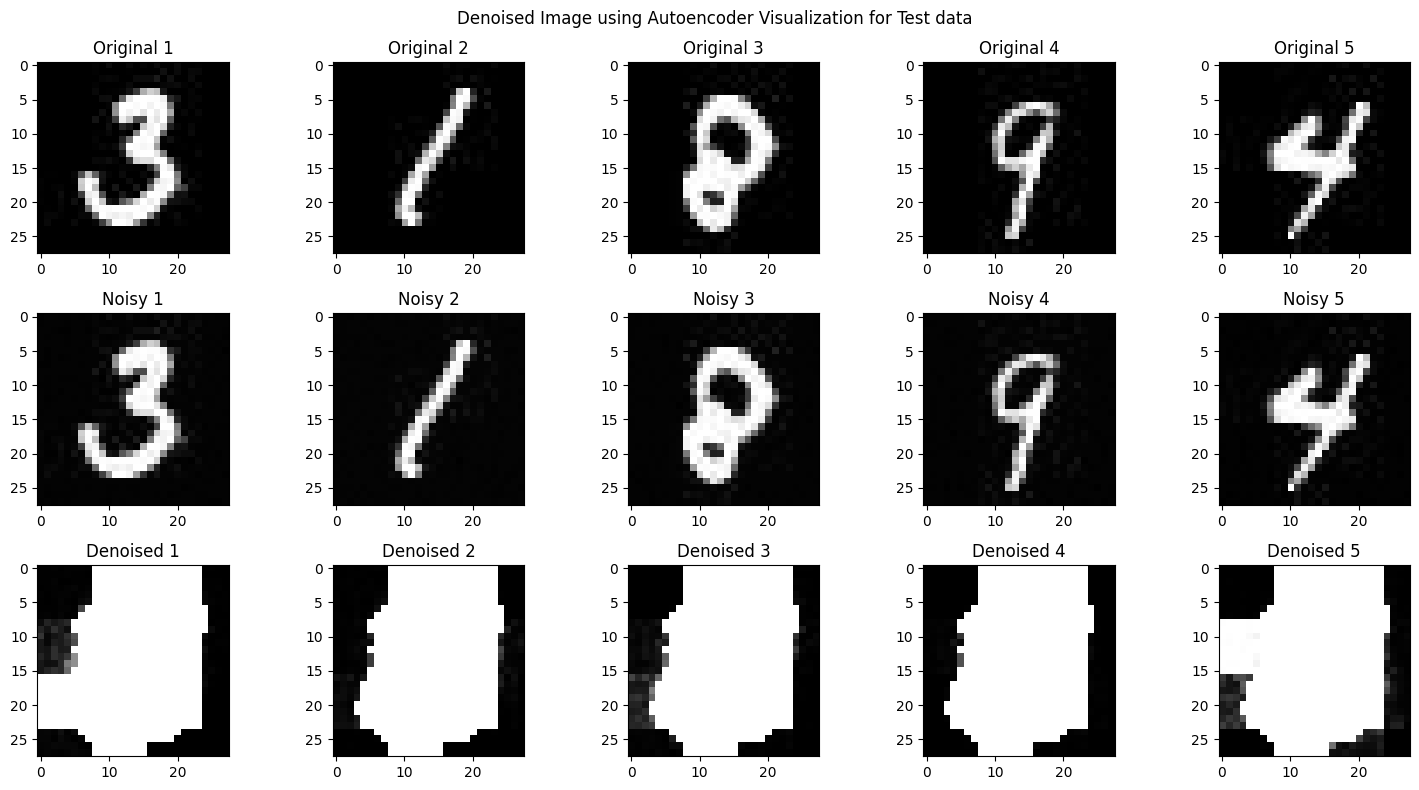

In [ ]:
# reconstruction visualise
imgs=random_reconstruct(denoiser,train_ip,train_target,"Training data")
reconstruct(denoiser,imgs,"Training data")

imgs=random_reconstruct(denoiser,val_ip,val_target,"Validation data")
reconstruct(denoiser,imgs,"Validation data")

imgs=random_reconstruct(denoiser,test_ip,test_target,"Test data")
reconstruct(denoiser,imgs,"Test data")

40% noise

In [28]:
denoiser=Autoencoder(784,[],256)
denoiser,results=train(denoiser,train_ip,val_ip,0.4)
autoencoder_performance(denoiser,results)
denoiser_4=denoiser

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               200960    
                                                                 
Total params: 200,960
Trainable params: 200,960
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 784)               201488    
                                                                 
Total params: 201,488
Trainable params: 201,488
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 19
Training loss : 6645.69873046875
Validation loss : 6672.94775390625




In [ ]:
noisy_train=add_noise(train_ip,0.4)
noisy_val=add_noise(val_ip,0.4)
noisy_test=add_noise(test_ip,0.4)
denoiser_train=denoiser.encoder(train_ip)
denoiser_val=denoiser.encoder(val_ip)
denoiser_test=denoiser.encoder(test_ip)

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 256)               65792     
                                                                 
 dense_136 (Dense)           (None, 128)               32896     
                                                                 
 dense_137 (Dense)           (None, 30)                3870      
                                                                 
 dense_138 (Dense)           (None, 5)                 155       
                                                                 
Total params: 102,713
Trainable params: 102,713
Non-trainable params: 0
_________________________________________________________________
None
Epochs : 53
Training accuracy : 83.13295245170593
Validation accuracy : 81.78243637084961
Training loss : 0.4716857671737671
Validation loss : 0.501600444316864


Performance

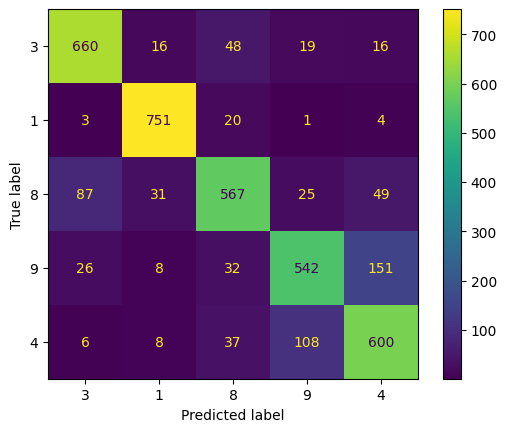

119/119 [==============================] - 0s 2ms/step - loss: 0.4854 - accuracy: 0.8314
Loss : 0.4853668510913849
Accuracy : 0.8313570618629456
Mean squared error : tf.Tensor(0.04996793, shape=(), dtype=float32)


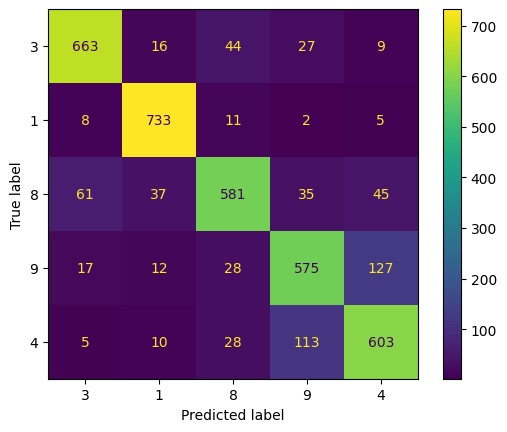

In [ ]:
hidden_layer_arch=[256,128,30]
model=build_FCNN(hidden_layer_arch,256,5)
model,results=train_model(model,denoiser_train,train_target,denoiser_val,val_target)
print(model.summary())
FCNN_performance(results)

print("Performance of the best model for 32 dimesional test data")
prediction(model,denoiser_val,val_target)
prediction(model,denoiser_test,test_target)

For Training data


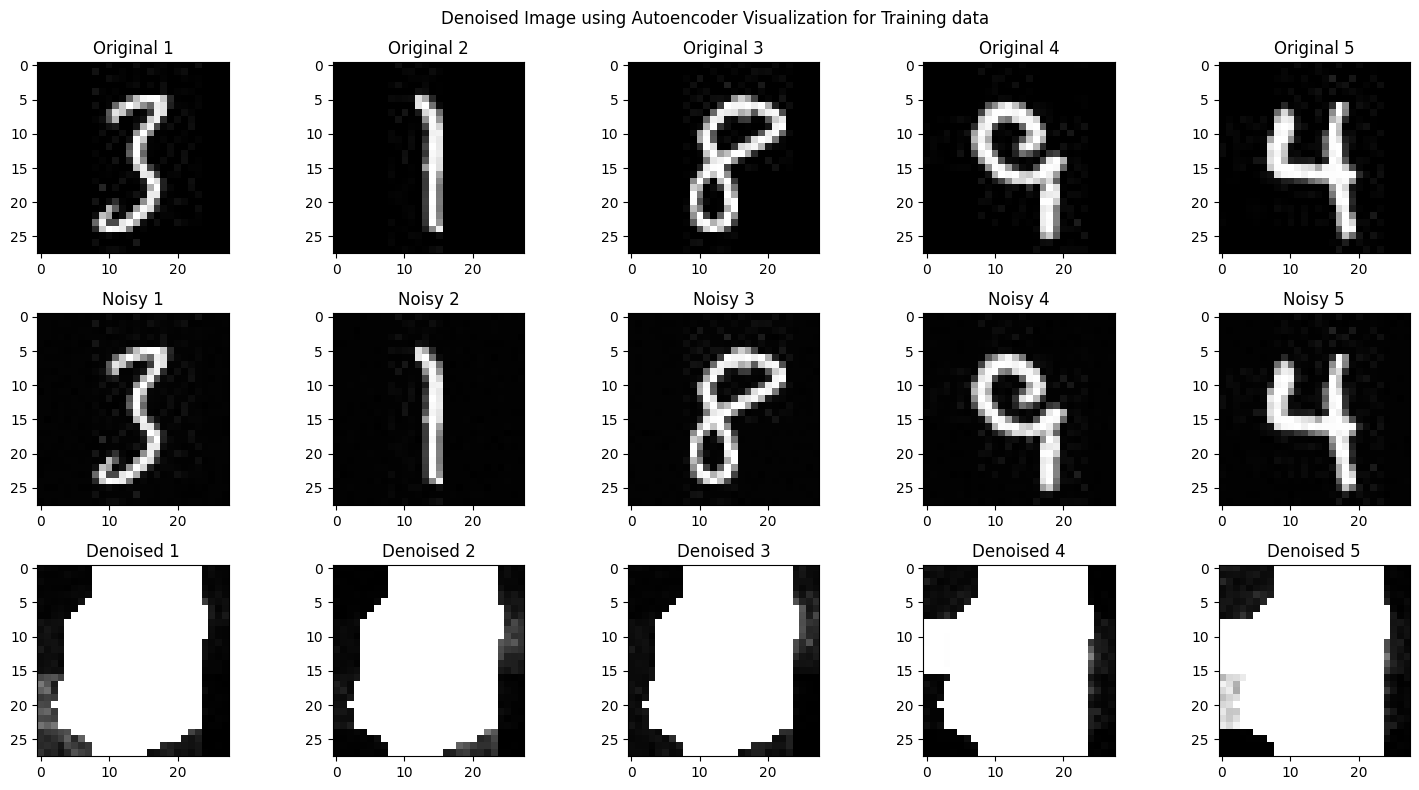

For Validation data


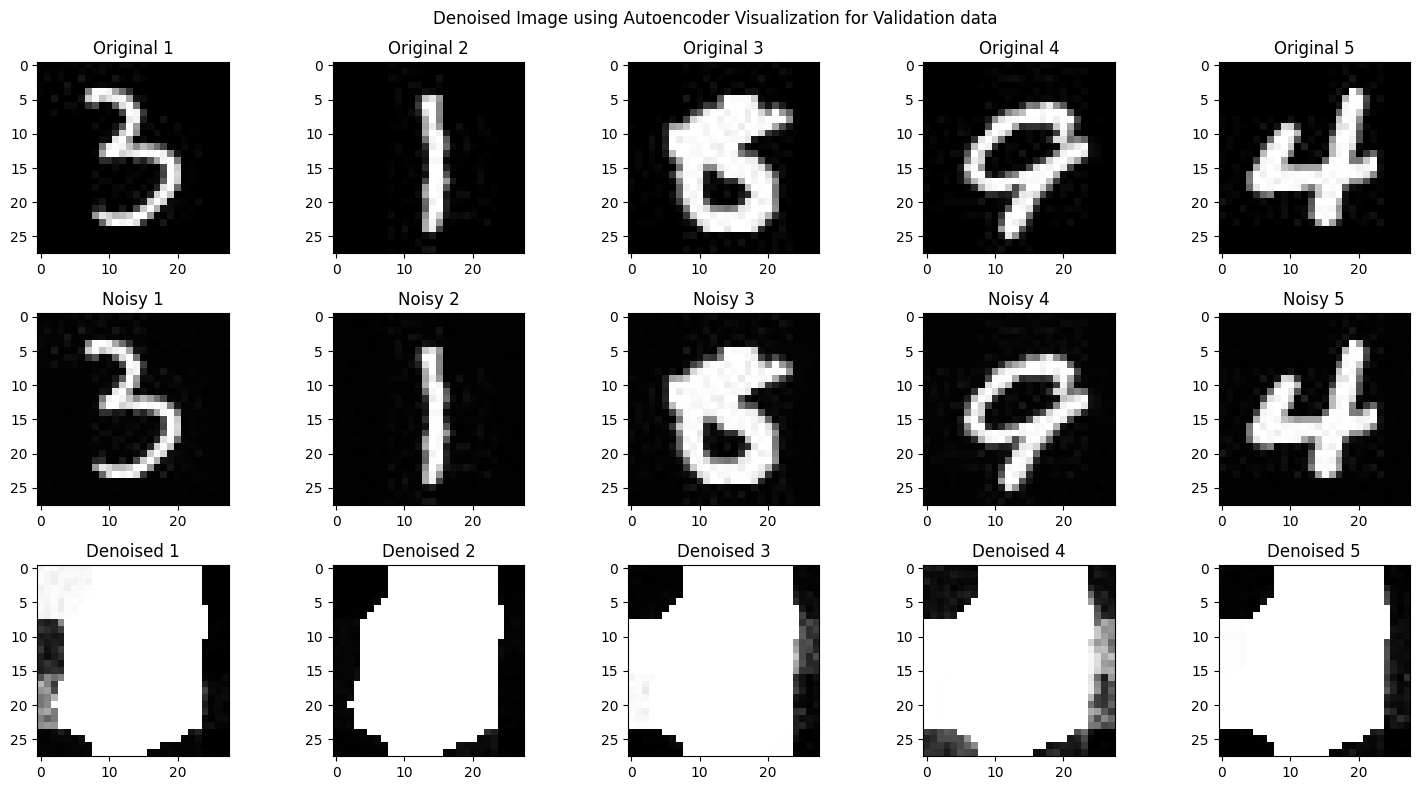

For Test data


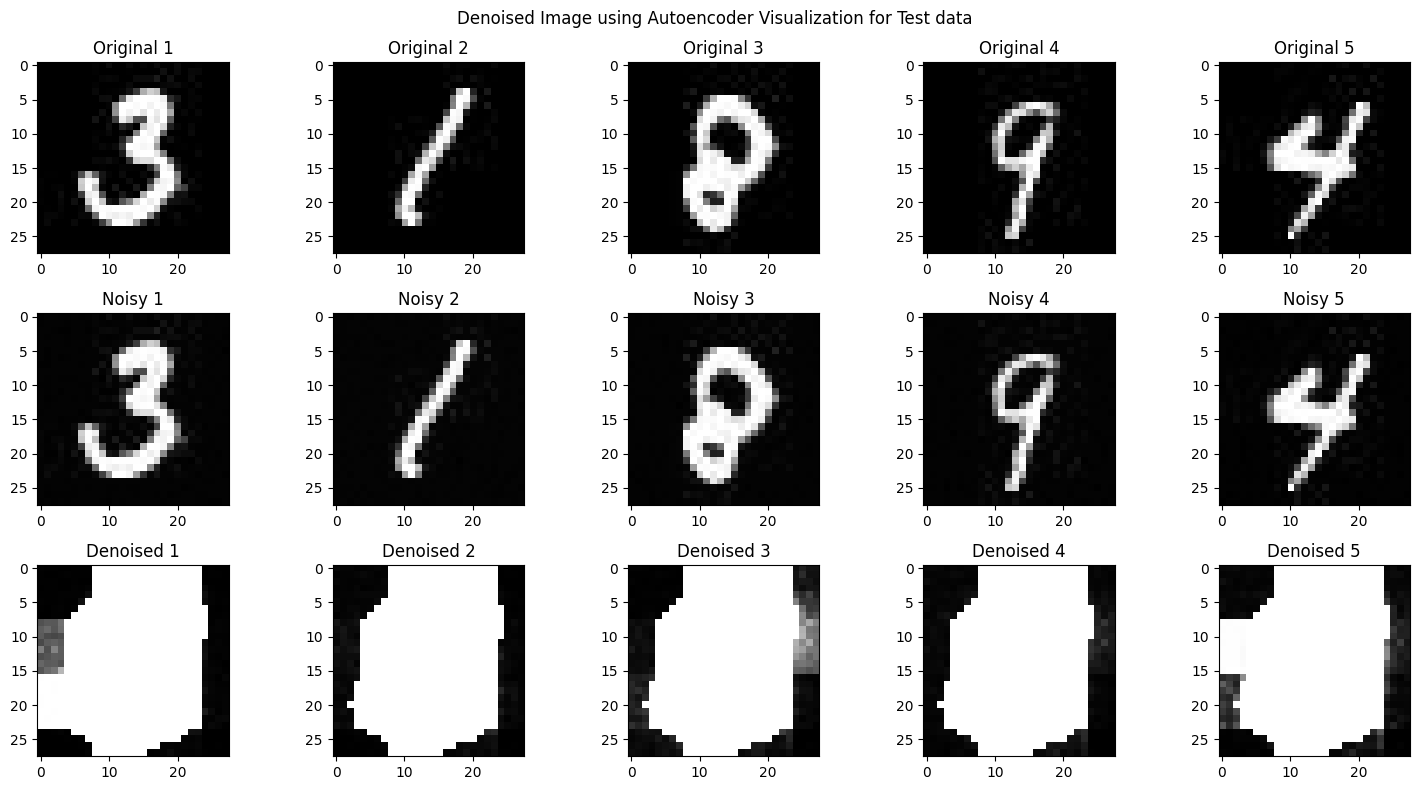

In [ ]:
# reconstruction visualise
imgs=random_reconstruct(denoiser,train_ip,train_target,"Training data")
reconstruct(denoiser,imgs,"Training data")

imgs=random_reconstruct(denoiser,val_ip,val_target,"Validation data")
reconstruct(denoiser,imgs,"Validation data")

imgs=random_reconstruct(denoiser,test_ip,test_target,"Test data")
reconstruct(denoiser,imgs,"Test data")

# Task 6 : Weight visualization

In [20]:
class WeightVisualizer():

  def __init__(self, autoencoder):
    self.autoencoder = autoencoder

  def get_weights_bottleneck(self, model):
    return model.encoder.layers[-1].get_weights()

  def plot_grid_weights(self, data):
    width = 8
    size = int(64/width)
    fig = plt.figure(figsize= (size, width*1.1))
    i=1
    for i in range(size):
      for j in range(width):
        fig.add_subplot( size, width , int(i*width + j + 1))
        img = np.reshape(data[int(i*width + j)], [28,28,1]).astype('float')
        plt.title(f"Neuron {int(i*width + j + 1)}", fontsize = 8)
        plt.axis('off')
        plt.imshow(img)
    plt.axis('off')
    plt.show()

  def maximal_activated_inputs(self):
    model = self.autoencoder
    weights = self.get_weights_bottleneck(model)[0].T
    data = [w/(np.linalg.norm(w)) for w in weights]
    self.plot_grid_weights(data)

1 hidden layer

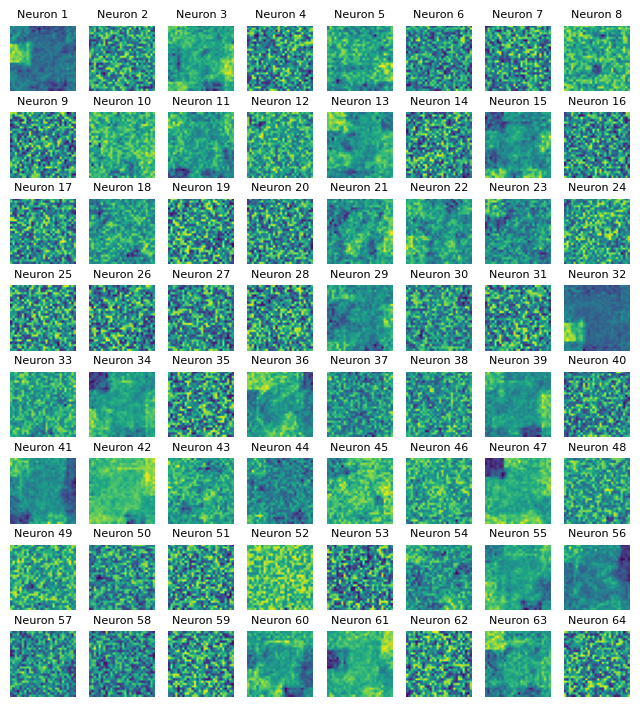

In [21]:
autoencoder_vis_model_256 = h1_layer_models[3]
layer_1_weigths_256 = WeightVisualizer(autoencoder_vis_model_256)
layer_1_weigths_256.maximal_activated_inputs()

20% noise

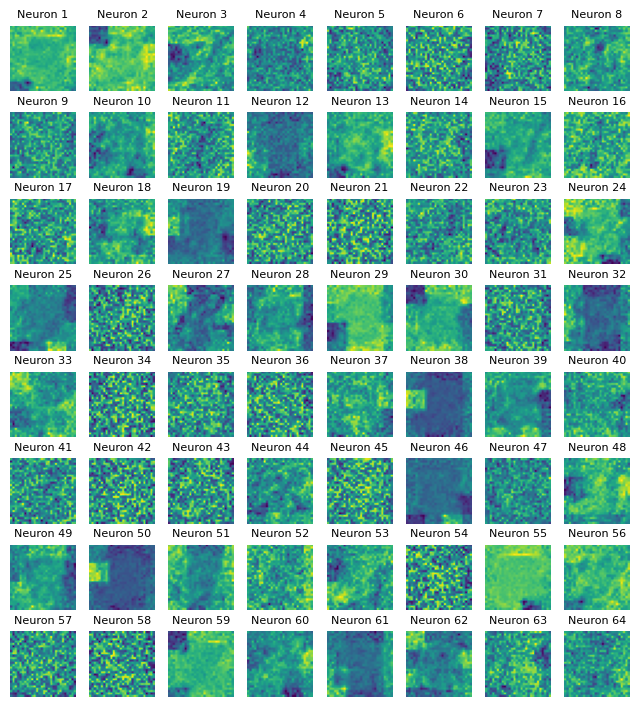

In [27]:
denoisy1_weights = WeightVisualizer(denoiser_2)
denoisy1_weights.maximal_activated_inputs()

40% noise

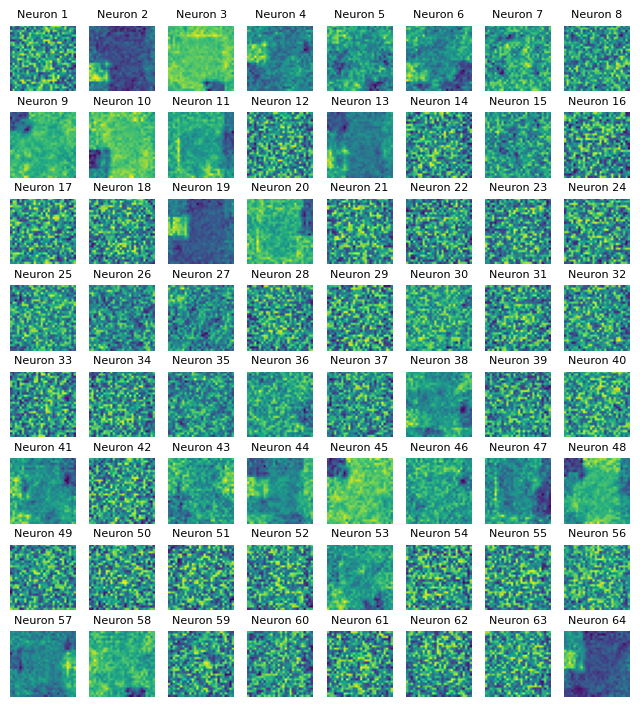

In [29]:
denoisy2_weights = WeightVisualizer(denoiser_4)
denoisy2_weights.maximal_activated_inputs()